# Imports

In [2]:
import sys
import os
import gc
import time
import random
import re
from tqdm import tqdm 
import json
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaTokenizer, LlamaForCausalLM, BatchEncoding
import matplotlib.pyplot as plt
from math import ceil
from sentence_transformers import SentenceTransformer

In [3]:
sys.path.append("/coc/pskynet6/dhe83/mice/src")

In [4]:
import config
import utils
from prompts import *

## Load Data

In [23]:
train = utils.read_jsonl("../data/WiC/train.jsonl")
train = {str(ex['idx']): ex for ex in train}
val = utils.read_jsonl("../data/WiC/val.jsonl")
val = {str(ex['idx']): ex for ex in val}

## Load Model

In [6]:
model_addr = "decapoda-research/llama-13b-hf"
tokenizer = LlamaTokenizer.from_pretrained(model_addr, use_fast=False, padding_side='left')
model = LlamaForCausalLM.from_pretrained(
    model_addr,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto'
)
print("done!")

Downloading:   0%|          | 0.00/500k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/141 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Downloading:   0%|          | 0.00/427 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/983M [00:00<?, ?B/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /srv/nlprx-lab/share6/dhe83/miniconda3/envs/mice/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /srv/nlprx-lab/share6/dhe83/miniconda3/envs/mice/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /srv/nlprx-lab/share6/dhe83/miniconda3/envs/mice/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/srv/nlprx-lab/share6/dhe83/miniconda3/envs/mice/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/srv/nlprx-lab/share6/dhe83/miniconda3/envs/mice/lib/libcudart.so'), PosixPath('/srv/nlprx-lab/share6/dhe83/miniconda3/envs/mice/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


Loading checkpoint shards:   0%|          | 0/41 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

done!


In [ ]:
model.config

In [7]:
# unwind broken decapoda-research config
model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
model.config.bos_token_id= 1
model.config.eos_token_id = 2

In [8]:
# model.half()
model.eval()
if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

# In-Context Analysis

In [9]:
def tokenize_progressive(dem, test):
    dem_tokens = tokenizer(dem, padding=True,return_tensors="pt").to('cuda')
    prompt_tokens = tokenizer(test, padding=True,return_tensors="pt").to('cuda')
    
    def progressive_context(input_ids):
        token_len = input_ids.shape[1]
        
        repeated = input_ids.repeat(token_len, 1)
        offset = torch.arange(token_len).unsqueeze(dim=-1).cuda()
        indices = torch.arange(token_len).repeat(token_len,1).cuda()
        
        indices = (indices - offset) % token_len
        
        tokens = torch.gather(repeated, -1, indices).triu()
        attention_mask = torch.ones_like(tokens).triu()
        
        return tokens.flip((0)), attention_mask.flip((0))

    def pad_demonstration(input_ids, mask):
        return F.pad(input_ids, (0,2), "constant", 13), F.pad(mask, (0,2), "constant", 1)
    
    context_ids, context_mask = progressive_context(dem_tokens.input_ids)
    context_ids, context_mask = pad_demonstration(context_ids, context_mask)
    
    no_pad = prompt_tokens.input_ids[:, 1:]
    repeated = no_pad.repeat(context_ids.shape[0], 1)
    mask_repeated = torch.ones_like(repeated)
    
    inputs = torch.cat((context_ids, repeated), 1)
    mask = torch.cat((context_mask, mask_repeated), 1)
    return BatchEncoding({'input_ids': inputs, 'attention_mask': mask})


In [15]:
def inference_wrapper(prompts: dict):
    prompts = {k: v for k, v in sorted(x.items(), key=lambda item: len(item[1]))}

def batch_inference(model, tokenizer, prompts, batch_size, mask_bos):
output_tokens = torch.empty(0, dtype=torch.int64).to('cuda:0')
first_token_scores = []
num_batches = ceil(len(prompts) / batch_size)

for batch in range(num_batches):
    start = batch * batch_size
    end = min((batch + 1) * batch_size, len(prompts))

    gen_len=5
    # tokenize by batch to mitigate effect of long outliers
    tokens = tokenizer(prompts[start:end], padding=True, return_tensors="pt").to('cuda:0')
    attention_mask = masked_bos(tokens.attention_mask) if mask_bos else tokens.attention_mask

    with torch.no_grad():
        outputs = model.generate(
            input_ids=tokens.input_ids,
            attention_mask=attention_mask,
            max_new_tokens=gen_len,
            temperature=0,
            return_dict_in_generate=True,
            output_scores=True,
        )
    output_tokens = torch.cat((output_tokens, outputs.sequences[:, -gen_len:]))
output_text = tokenizer.batch_decode(output_tokens)
return output_text      

IndentationError: expected an indented block (3966770755.py, line 5)

In [13]:
def batch_inference(tokenized):    
    batch_size=4
    num_prompts = tokenized.input_ids.shape[0]
    num_batches = ceil(num_prompts / batch_size)
    output_tokens = torch.empty(0, dtype=torch.int64).to('cuda:0')
    output_scores = torch.empty(0, dtype=torch.float16).to('cuda:0')
    
    for batch in tqdm(range(num_batches)): 
        start = batch * batch_size
        end = min((batch + 1) * batch_size, num_prompts)
        
        # tokenize by batch to mitigate effect of long outliers
        input_ids = tokenized.input_ids[start:end, :]
        mask = tokenized.attention_mask[start:end, :]
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=mask,
            max_new_tokens=1,
            temperature=0,
            return_dict_in_generate=True,
            output_scores=True,
        )
        output_tokens = torch.cat((output_tokens, outputs.sequences[:, -1].to('cuda:0')))
        output_scores = torch.cat((output_scores, outputs.scores[0].to('cuda:0')), dim=0)
        
    return output_tokens, output_scores

In [37]:
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to("cuda")
def embed(data, dataset, model):
    print("Embedding train examples...", end="")
    embeddings = {}
    for idx, ex in tqdm(data.items()):
        text = format_in_context(ex, dataset)
#         text = ex['question']
        embeddings[idx] = torch.tensor(model.encode(text))
    print("done!")
    return embeddings
    
def similarity_scores(test_example, embeddings, dataset, model):
    test_prompt = format_example(test_example, dataset)
#     test_prompt = test_example['question']
    test_embedding = torch.tensor(model.encode(test_prompt))
    train_embeddings = embeddings

    similarity = torch.nn.CosineSimilarity(dim=1)
    
    print("Scoring similarity...", end="")
    similarity_list = sorted([(idx, similarity(
                                test_embedding.unsqueeze(0),
                                train_embedding.unsqueeze(0),).item())
                                for idx, train_embedding in tqdm(train_embeddings.items())], 
                             key=lambda x: x[1], reverse=True)
    print("done!")
    
    return similarity_list

### Zero-Shot

In [18]:
single = tokenizer(test, return_tensors="pt").to('cuda:0')
single_output = model.generate(
    **single,
    max_new_tokens=5,
    temperature=0,
    return_dict_in_generate=True,
    output_scores=True,
)
text = tokenizer.decode(single_output.sequences[0, :])

NameError: name 'test' is not defined

In [ ]:
scores = single_output.scores[0]

In [ ]:
scores[0]

In [12]:
yes = [3869, 4874, 5852, 1565]
no = [1939, 694, 7700, 2089]

In [19]:
probs = scores[0].log_softmax(-1).exp()
yes_probs = probs[yes].sum(-1)
no_probs = probs[no].sum(-1)

NameError: name 'scores' is not defined

In [146]:
yes_probs.item()

0.26171875

In [147]:
no_probs.item()

0.130615234375

### Progressive Prompting

In [15]:
def plot_progressive(dem, test):
    yes = [3869, 4874, 5852, 1565]
    no = [1939, 694, 7700, 2089]
    
    
    tokens = tokenize_progressive("\n\n".join(dem), test)
    sequences, scores = batch_inference(tokens)
    
    print("\n\n".join([*dem, test]))
    print(tokenizer.decode(sequences[-1]))
    
    probs = scores.log_softmax(-1).exp()
    yes_probs = probs[:, yes].sum(-1)
    no_probs = probs[:, no].sum(-1)
    
    plt.plot(yes_probs.cpu(), color='green', label='Yes')
    plt.plot(no_probs.cpu(), color='red', label='No')

    plt.xlabel('Tokens')
    plt.ylabel('Probability')
    plt.title('Answer Probs')

    plt.legend()
    plt.show()

In [27]:
dataset = "WiC"

In [96]:
ex = val['330']
test = format_example(ex, dataset)

In [97]:
ex

{'word': 'inject',
 'sentence1': 'Inject hydrogen into the balloon.',
 'sentence2': 'Now lie back while we inject you with the anesthetic.',
 'idx': 330,
 'label': False,
 'start1': 0,
 'start2': 22,
 'end1': 6,
 'end2': 28,
 'version': 1.1}

In [98]:
few = random.sample(list(train), k =32)
few = {train[x]['idx']: train[x] for x in few}

In [99]:
train_embeddings = embed(few, dataset, encoder)

Embedding train examples...

100%|███████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 193.85it/s]

done!


In [100]:
similarity_list = similarity_scores(ex, train_embeddings, dataset, encoder)

Scoring similarity...

100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 23852.45it/s]

done!


In [112]:
demonstrations = []

In [113]:
for x in similarity_list[:5]:
    d = format_in_context(train[str(x[0])], dataset)
    demonstrations.append(d)
    print(x[0], d)
    print("*" * 20)

2519 The use of torture has been condemned by the United Nations.
He warned against the use of narcotic drugs.
question: Is the word 'use' used in the same way in the two sentences above?answer: yes
********************
2435 We take all major credit cards.
Do you take sugar in your coffee?
question: Is the word 'take' used in the same way in the two sentences above?answer: yes
********************
3489 Dew dripped from the face of the leaf.
He looked out at a roomful of faces.
question: Is the word 'face' used in the same way in the two sentences above?answer: no
********************
928 Draw parallels.
Draw a conclusion.
question: Is the word 'draw' used in the same way in the two sentences above?answer: yes
********************
781 I shall be writing to you soon.
The postman has been today, but my tickets have still not yet come.
question: Is the word 'be' used in the same way in the two sentences above?answer: yes
********************


In [107]:
for x in reversed(demonstrations):
    print(x)
print(test)

Magnolias belong to the order Magnoliales.
It was on the order of a mile.
question: Is the word 'order' used in the same way in the two sentences above?answer: no
Wear one's hair in a certain way.
He always wears a smile.
question: Is the word 'wear' used in the same way in the two sentences above?answer: no
A sense of danger.
A sense of security.
question: Is the word 'sense' used in the same way in the two sentences above?answer: yes
He bought his brother's business.
Business has been slow lately.
question: Is the word 'business' used in the same way in the two sentences above?answer: no
We have a fix on your position.
He got a good fix on the target.
question: Is the word 'fix' used in the same way in the two sentences above?answer: yes
I shall be writing to you soon.
The postman has been today, but my tickets have still not yet come.
question: Is the word 'be' used in the same way in the two sentences above?answer: yes
Draw parallels.
Draw a conclusion.
question: Is the word 'draw'

In [104]:
ex

{'word': 'inject',
 'sentence1': 'Inject hydrogen into the balloon.',
 'sentence2': 'Now lie back while we inject you with the anesthetic.',
 'idx': 330,
 'label': False,
 'start1': 0,
 'start2': 22,
 'end1': 6,
 'end2': 28,
 'version': 1.1}

100%|████████████████████████████████████████████████████████████████| 54/54 [00:24<00:00,  2.23it/s]

Inject hydrogen into the balloon.
Now lie back while we inject you with the anesthetic.
question: Is the word 'inject' used in the same way in the two sentences above?answer:
no


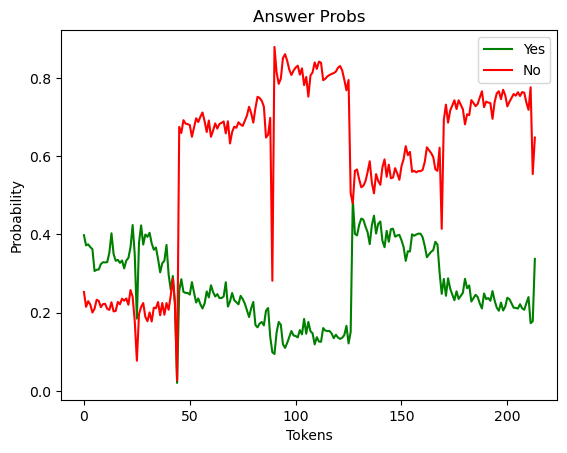

In [111]:
plot_progressive(reversed(demonstrations), test)

100%|████████████████████████████████████████████████████████████████| 57/57 [00:26<00:00,  2.16it/s]

Inject hydrogen into the balloon.
Now lie back while we inject you with the anesthetic.
question: Is the word 'inject' used in the same way in the two sentences above?answer:
yes


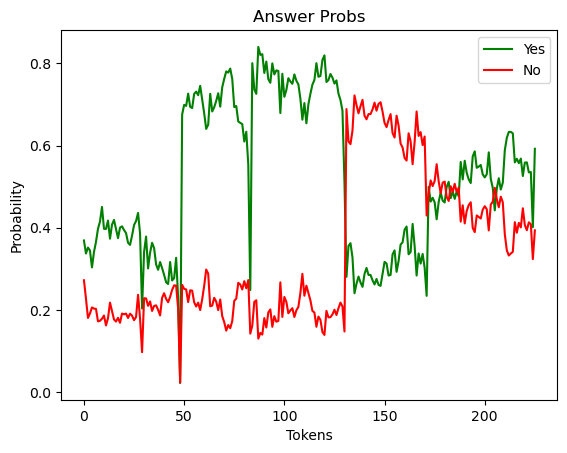

In [114]:
plot_progressive(reversed(demonstrations), test)

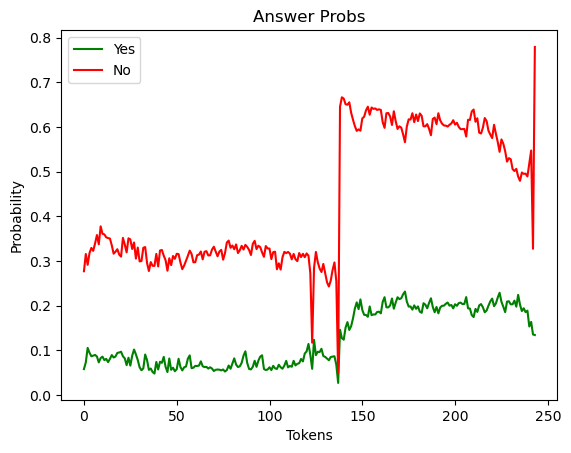

In [109]:
#no_no
plt.plot(saved_yes["no_no"].cpu(), color='green', label='Yes')
plt.plot(saved_no["no_no"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs (No, No)')

plt.legend()
plt.show()

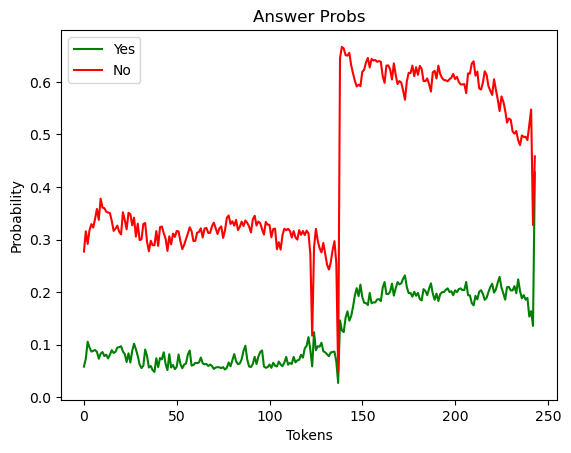

In [108]:
#no_yes
plt.plot(saved_yes["no_yes"].cpu(), color='green', label='Yes')
plt.plot(saved_no["no_yes"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs')

plt.legend()
plt.show()

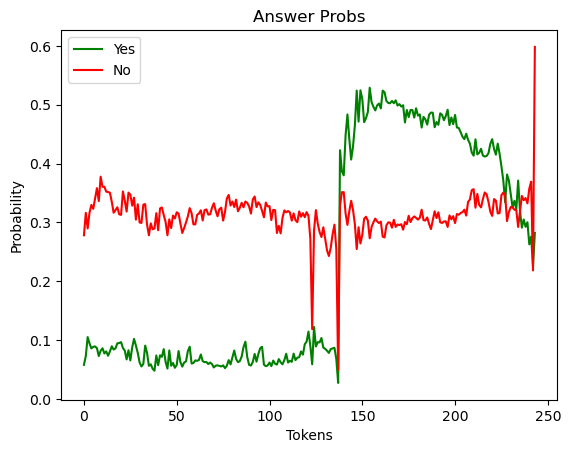

In [88]:
#yes_no
plt.plot(saved_yes["yes_no"].cpu(), color='green', label='Yes')
plt.plot(saved_no["yes_no"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs')

plt.legend()
plt.show()

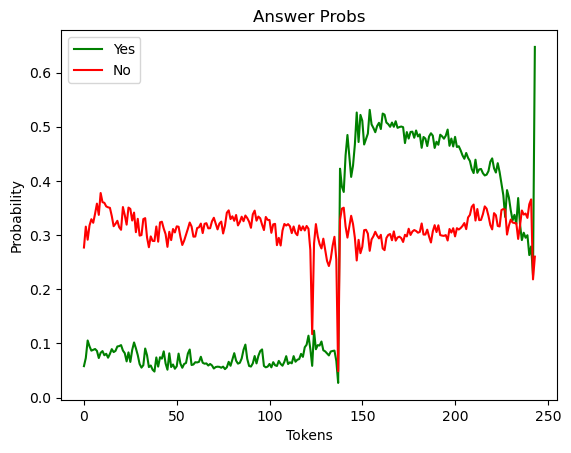

In [106]:
#yes_yes
plt.plot(saved_yes["yes_yes"].cpu(), color='green', label='Yes')
plt.plot(saved_no["yes_yes"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs')

plt.legend()
plt.show()

In [23]:
print(torch.cuda.mem_get_info())
print(torch.cuda.memory_summary())

(33548468224, 47850782720)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    6957 MB |   11955 MB |   17827 GB |   17820 GB |
|       from large pool |    6854 MB |   11850 MB |   17446 GB |   17439 GB |
|       from small pool |     103 MB |     108 MB |     381 GB |     381 GB |
|---------------------------------------------------------------------------|
| Active memory         |    6957 MB |   11955 MB |   17827 GB |   17820 GB |
|       from large pool |    6854 MB 

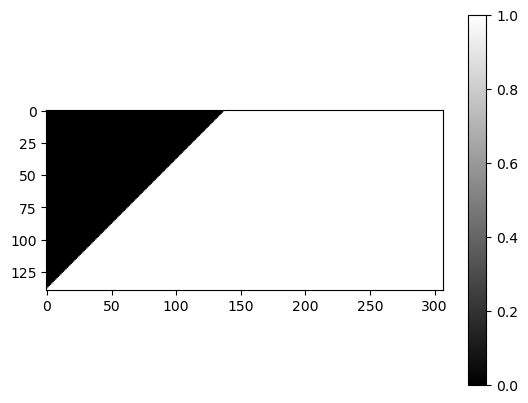

In [120]:
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def scores(inputs, outputs):
    transition_scores = model.compute_transition_scores(
        outputs.sequences, outputs.scores, normalize_logits=True
    )
    # input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for
    # encoder-decoder models, like BART or T5.
    input_length = inputs.input_ids.shape[1]
    generated_tokens = outputs.sequences[:, input_length:]
    probs = {}
    print(generated_tokens)
    for tok, score in zip(generated_tokens[0], transition_scores[0]):
        # | token | token string | logits | probability
        print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score:.3f} | {torch.exp(score):.2%}")
        probs[tokenizer.decode(tok)] = torch.exp(score).item()
    return probs

In [ ]:
q1 = "question: is a aba number the same as a routing number\nanswer:"
q2 = "question: is the vampire diaries related to the originals\nanswer:"
qs = [q1, q2]
ans = [" yes", " no"]
iclist = [q + a for q in [*qs, *reversed(qs)] for a in [*ans, *ans]]

In [ ]:
def batch_inference(tokenized):    
    batch_size=16
    num_prompts = tokenized.input_ids.shape[0]
    num_batches = ceil(num_prompts / batch_size)
    output_tokens = torch.empty(0, dtype=torch.int64).to('cuda:0')
    output_scores = torch.empty(0, dtype=torch.float16).to('cuda:0')
    
    for batch in tqdm(range(num_batches)): 
        start = batch * batch_size
        end = min((batch + 1) * batch_size, num_prompts)
        
        # tokenize by batch to mitigate effect of long outliers
        input_ids = tokenized.input_ids[start:end, :]
        mask = tokenized.attention_mask[start:end, :]
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=mask,
            max_new_tokens=1,
            temperature=0,
            return_dict_in_generate=True,
            output_scores=True,
        )
        output_tokens = torch.cat((output_tokens, outputs.sequences[:, -1]))
        output_scores = torch.cat((output_scores, outputs.scores[0]), dim=0)
        
    return output_tokens, output_scores